# Setup & Load Data

In [8]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import networkx as nx

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 10})

RAW_DIR   = Path("./ Data")
OUT_DIR   = Path("./DataAfterProcessing")
PROC_DIR  = OUT_DIR / "Processed"
STATS_DIR = OUT_DIR / "Stats"
STATS_DIR.mkdir(parents=True, exist_ok=True)
RULES_PATH = Path("./Models/Rules")

F_PRODUCTS_ENRICHED = PROC_DIR / "products_enriched.csv"
F_TX_LONG          = PROC_DIR / "transactions_long.csv"
ITEM_RULES = RULES_PATH / "item_rules.csv"
CAT_RULES = RULES_PATH / "category_rules.csv"

products = pd.read_csv(F_PRODUCTS_ENRICHED)
tx_long  = pd.read_csv(F_TX_LONG)
item_rules = pd.read_csv(ITEM_RULES)
cat_rules = pd.read_csv(CAT_RULES)

print(f"Products shape: {products.shape}")
print(f"Transactions shape: {tx_long.shape}")

Products shape: (12877, 15)
Transactions shape: (49786, 11)


# Tổng quan dữ liệu

In [9]:
n_products = products["product_id_str"].nunique()
n_brands   = products["brand_name"].nunique()
n_cats     = products["category_name"].nunique()
n_parent   = products["parent_category_name"].replace("", np.nan).nunique()
n_bills    = tx_long["bill_id"].nunique()

print("=== TỔNG QUAN DỮ LIỆU ===")
print("Số sản phẩm:", n_products)
print("Số thương hiệu:", n_brands)
print("Số category (child):", n_cats)
print("Số parent category:", n_parent)
print("Số bill:", n_bills)

print("Top 15 parent categories by number of products:")
top_parent = (products.groupby("parent_category_name")["product_id_str"].nunique()
              .sort_values(ascending=False).head(15))
top_parent

=== TỔNG QUAN DỮ LIỆU ===
Số sản phẩm: 12877
Số thương hiệu: 1431
Số category (child): 261
Số parent category: 86
Số bill: 4430
Top 15 parent categories by number of products:


parent_category_name
Dụng Cụ Bếp, Phòng Ăn       1033
Bánh Kẹo                     615
Mì, Bún, Topokki Ăn Liền     547
Bánh Các Loại                490
Chăm Sóc Tóc                 424
Sốt, Gia Vị Các Loại         417
Làm Sạch Cơ Thể              411
Nước Ngọt                    364
Hạt, Trái Cây Sấy            317
Sữa Nước                     315
Snack, Ăn Vặt                312
Đồ Uống                      267
Rau Củ                       258
Chăm Sóc Da Mặt              244
Rượu                         238
Name: product_id_str, dtype: int64

# Basket Analysis

--- THỐNG KÊ KÍCH THƯỚC GIỎ HÀNG (Sản phẩm/Bill) ---
count    4430.00
mean       11.24
std         3.60
min         5.00
25%         8.00
50%        11.00
75%        14.00
max        22.00
Name: product_id_str, dtype: float64

- Trung bình 1 bill có: 11.24 sản phẩm
- Bill mua ít nhất: 5 sản phẩm
- Bill mua nhiều nhất: 22 sản phẩm
- 75% số bill có dưới: 14 sản phẩm


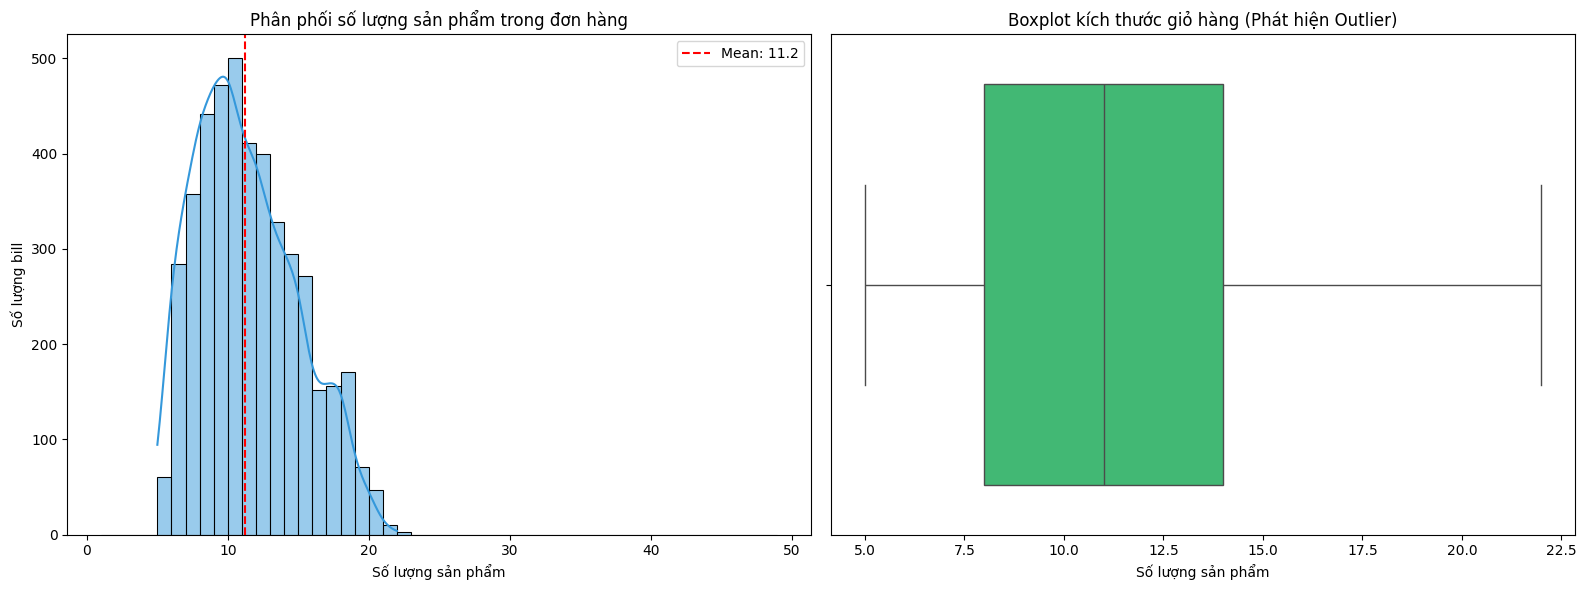

In [10]:
# --- BASKET ANALYSIS (Hành vi User) ---

# Group by bill_id để đếm số lượng sản phẩm trong mỗi bill
basket_sizes = tx_long.groupby("bill_id")['product_id_str'].count()

# Thống kê mô tả
print("--- THỐNG KÊ KÍCH THƯỚC GIỎ HÀNG (Sản phẩm/Bill) ---")
print(basket_sizes.describe().round(2))
print(f"\n- Trung bình 1 bill có: {basket_sizes.mean():.2f} sản phẩm")
print(f"- Bill mua ít nhất: {basket_sizes.min()} sản phẩm")
print(f"- Bill mua nhiều nhất: {basket_sizes.max()} sản phẩm")
print(f"- 75% số bill có dưới: {basket_sizes.quantile(0.75):.0f} sản phẩm")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Histogram phân phối
sns.histplot(basket_sizes, bins=range(1, 50), kde=True, ax=ax[0], color='#3498db')
ax[0].set_title("Phân phối số lượng sản phẩm trong đơn hàng")
ax[0].set_xlabel("Số lượng sản phẩm")
ax[0].set_ylabel("Số lượng bill")
ax[0].axvline(basket_sizes.mean(), color='red', linestyle='--', label=f'Mean: {basket_sizes.mean():.1f}')
ax[0].legend()

# Biểu đồ 2: Boxplot để xem Outlier (những bill mua sỉ cực lớn)
sns.boxplot(x=basket_sizes, ax=ax[1], color='#2ecc71')
ax[1].set_title("Boxplot kích thước giỏ hàng (Phát hiện Outlier)")
ax[1].set_xlabel("Số lượng sản phẩm")

plt.tight_layout()
plt.show()

# Product Popularity


--- THỐNG KÊ TẦN SUẤT SẢN PHẨM (Số Bill chứa sản phẩm đó) ---
count    6488.00
mean        7.67
std         8.15
min         1.00
25%         2.00
50%         4.00
75%        13.00
max        64.00
Name: count, dtype: float64

- Trung bình 1 sản phẩm xuất hiện trong: 7.67 bill
- Sản phẩm xuất hiện nhiều nhất: 64 bill
- Sản phẩm xuất hiện ít nhất: 1 bill
- Số lượng sản phẩm chỉ xuất hiện đúng 1 lần: 951 (14.66%)


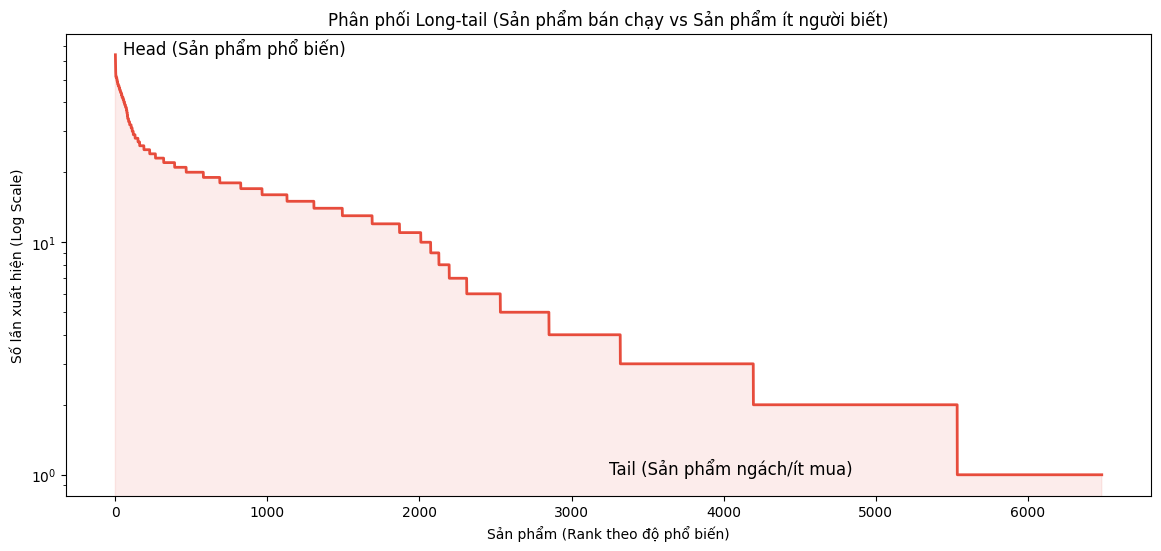

Top 10 sản phẩm xuất hiện nhiều nhất:


,product_id_str,count,product_name_vi
0,68312a85419bc51ab2ee7277,64,Cháo Ăn Liền Vifon Vị Cá Gói 50g
1,68312d4b419bc51ab2ee76ef,56,Miến Phú Hương Vị Gà Gói 53G
2,68312d66419bc51ab2ee771b,54,Phở Trộn Long Triều Bò Tái Lăn Vifon Gói 90G
3,68312a93419bc51ab2ee728e,52,Cháo Ăn Liền Ottogi Gà Dinh Dưỡng Hộp 285G
4,68312a89419bc51ab2ee727e,52,Cháo Ăn Liền Vị Rau Củ Dongwon 285g
5,68312a93419bc51ab2ee728f,51,Cháo Ăn Liền Ottogi Bào Ngư Hộp 285G
6,68312d66419bc51ab2ee771a,51,Phở Trộn Long Triều Hải Sản Cay Vifon Gói 90G
7,68313957419bc51ab2ee89ea,51,Khăn Bếp Đa Năng Bless You À La Vie 2 Lớp Lốc ...
8,6831397a419bc51ab2ee8a22,51,Khăn Giấy Rút Paseo 2 Lớp Gói 220 Tờ
9,68312d45419bc51ab2ee76e5,51,Miến Ăn Liền Vị Lẩu Cay Ottogi Ly 38.1G


In [11]:
# --- PRODUCT POPULARITY (Độ phủ Sản phẩm) ---

# Đếm số lần xuất hiện của mỗi sản phẩm trong các bill
item_counts = tx_long['product_id_str'].value_counts()

print("\n--- THỐNG KÊ TẦN SUẤT SẢN PHẨM (Số Bill chứa sản phẩm đó) ---")
print(item_counts.describe().round(2))
print(f"\n- Trung bình 1 sản phẩm xuất hiện trong: {item_counts.mean():.2f} bill")
print(f"- Sản phẩm xuất hiện nhiều nhất: {item_counts.max()} bill")
print(f"- Sản phẩm xuất hiện ít nhất: {item_counts.min()} bill")
print(f"- Số lượng sản phẩm chỉ xuất hiện đúng 1 lần: {(item_counts == 1).sum()} ({((item_counts == 1).sum()/len(item_counts)*100):.2f}%)")

# Trực quan hóa Long-tail Distribution
plt.figure(figsize=(14, 6))
y_values = item_counts.values
x_values = range(len(y_values))

plt.plot(x_values, y_values, color='#e74c3c', linewidth=2)
plt.fill_between(x_values, y_values, color='#e74c3c', alpha=0.1)

plt.title("Phân phối Long-tail (Sản phẩm bán chạy vs Sản phẩm ít người biết)")
plt.xlabel("Sản phẩm (Rank theo độ phổ biến)")
plt.ylabel("Số lần xuất hiện (Log Scale)")
plt.yscale('log') # Quan trọng: Dùng Log scale để nhìn rõ phần đuôi

# Annotation
plt.text(50, y_values[0], 'Head (Sản phẩm phổ biến)', fontsize=12, color='black')
plt.text(len(y_values)/2, 1, 'Tail (Sản phẩm ngách/ít mua)', fontsize=12, color='black')

plt.show()

# Lấy Top 10 sản phẩm
top_10_stats = item_counts.head(10).reset_index()

# Cột 1 là ID sản phẩm, Cột 2 là Số lượng đếm được
top_10_stats.columns = ['product_id_str', 'count']

# Lấy thông tin tên sản phẩm từ bảng products
top_10_info = products[products['product_id_str'].isin(top_10_stats['product_id_str'])][['product_id_str', 'product_name_vi']]

# Merge và hiển thị
print("Top 10 sản phẩm xuất hiện nhiều nhất:")
display(pd.merge(top_10_stats, top_10_info, on='product_id_str', how='left'))

# Category Penetration


--- THỐNG KÊ ĐỘ PHỦ NGÀNH HÀNG (Số bill chứa Category đó) ---
count     216.00
mean      169.53
std       313.61
min         1.00
25%        13.00
50%        46.00
75%       186.00
max      2310.00
Name: bill_id, dtype: float64

- Tổng số ngành hàng (Categories): 216
- Trung bình 1 Category xuất hiện trong: 169.53 bill
- Category phổ biến nhất: Bánh Snack (2310 bill)


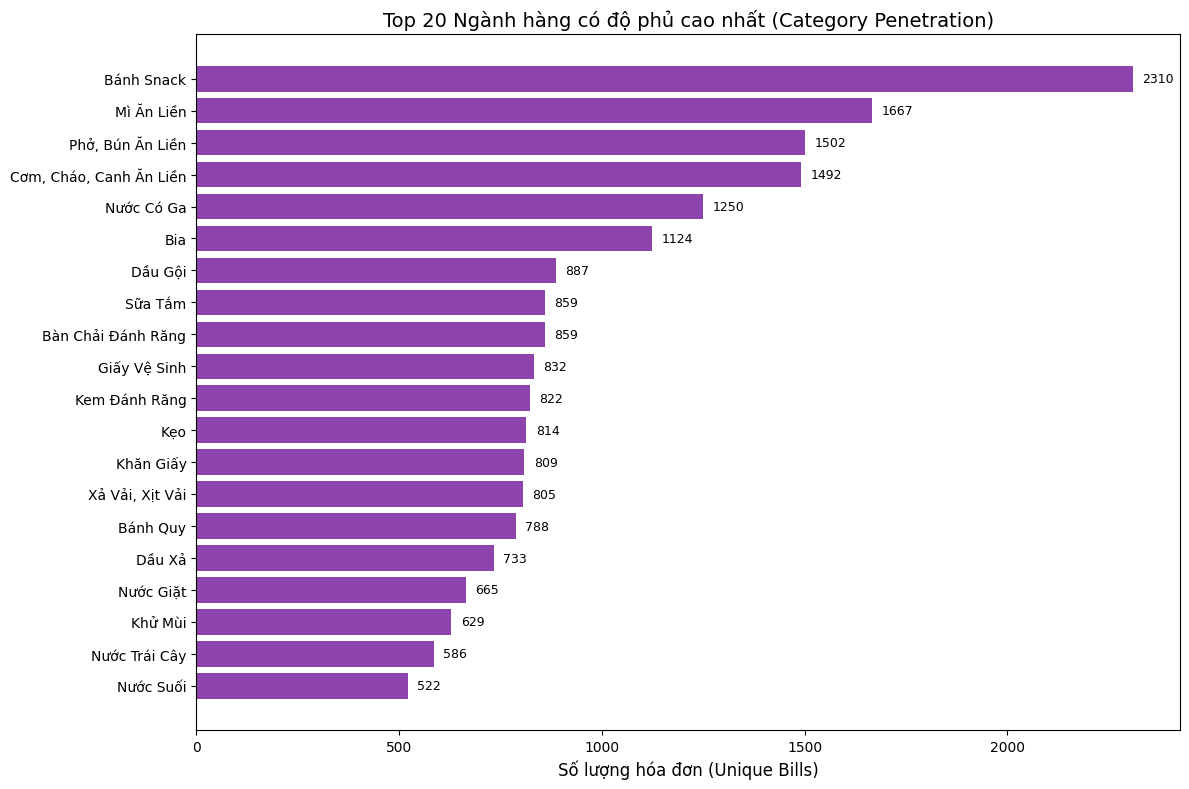

In [12]:
# --- CATEGORY PENETRATION (Độ phủ Ngành hàng) ---

# Chuyển về string, xóa khoảng trắng thừa, xử lý Null
tx_long['category_name'] = tx_long['category_name'].fillna('Unknown Category').astype(str).str.strip()

# Đếm số bill unique mà mỗi category xuất hiện
# (Logic: Trong 1 bill, dù mua 10 món thuộc 'Sữa' thì chỉ tính là 1 lần 'Sữa' xuất hiện trong bill đó)
cat_stats = tx_long.groupby('category_name')['bill_id'].nunique().sort_values(ascending=False)

print("\n--- THỐNG KÊ ĐỘ PHỦ NGÀNH HÀNG (Số bill chứa Category đó) ---")
print(cat_stats.describe().round(2))
print(f"\n- Tổng số ngành hàng (Categories): {len(cat_stats)}")
print(f"- Trung bình 1 Category xuất hiện trong: {cat_stats.mean():.2f} bill")
print(f"- Category phổ biến nhất: {cat_stats.index[0]} ({cat_stats.max()} bill)")

plt.figure(figsize=(12, 8))

# Lấy Top 20 Category phổ biến nhất
top_20_cat = cat_stats.head(20).sort_values(ascending=True)

# Cắt ngắn tên nếu quá dài (trên 50 ký tự) để biểu đồ đẹp hơn
y_labels = [name[:50] + '...' if len(name) > 50 else name for name in top_20_cat.index]

# Vẽ biểu đồ ngang
bars = plt.barh(y_labels, top_20_cat.values, color='#8e44ad')

plt.title("Top 20 Ngành hàng có độ phủ cao nhất (Category Penetration)", fontsize=14)
plt.xlabel("Số lượng hóa đơn (Unique Bills)", fontsize=12)

# Thêm nhãn số liệu (Data Labels) vào cuối thanh bar
for bar in bars:
    width = bar.get_width()
    # Hiển thị số liệu ngay bên phải thanh bar
    plt.text(width + (cat_stats.max() * 0.01), 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Rules Statistics

Số lượng luật sản phẩm (item_rules): 258
Số lượng luật ngành hàng (cat_rules): 869


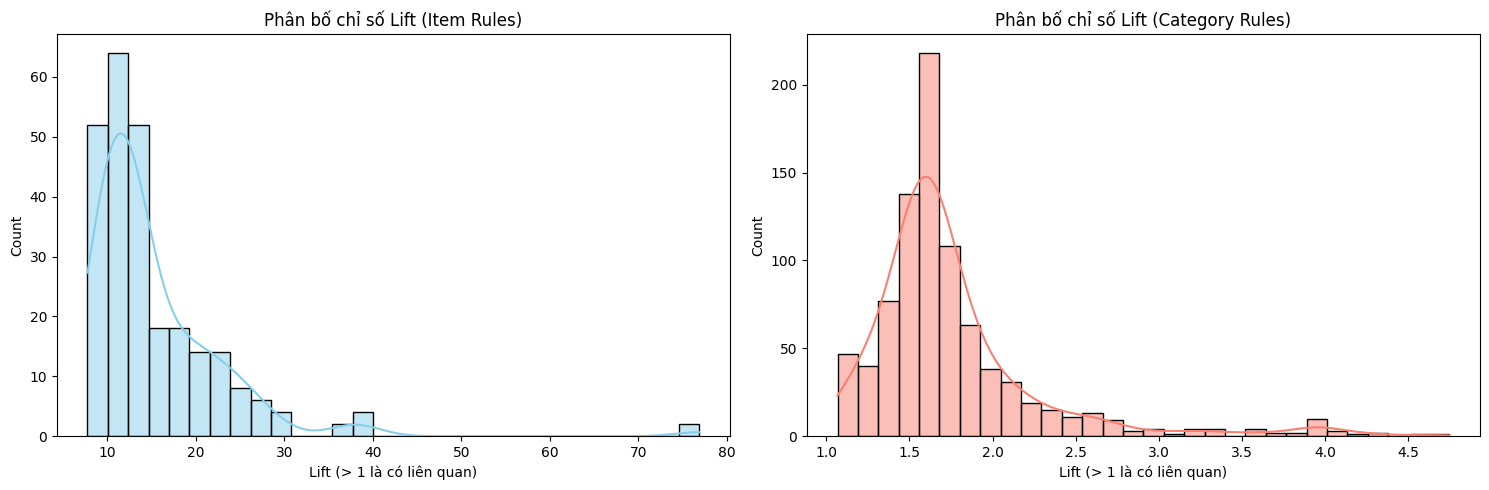

In [13]:
    # --- THỐNG KÊ TỔNG QUAN VỀ RULES ---
    print(f"Số lượng luật sản phẩm (item_rules): {len(item_rules)}")
    print(f"Số lượng luật ngành hàng (cat_rules): {len(cat_rules)}")

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Biểu đồ phân bố Lift cho Item Rules
    sns.histplot(item_rules['lift'], bins=30, kde=True, ax=ax[0], color='skyblue')
    ax[0].set_title('Phân bố chỉ số Lift (Item Rules)')
    ax[0].set_xlabel('Lift (> 1 là có liên quan)')

    # Biểu đồ phân bố Lift cho Category Rules
    sns.histplot(cat_rules['lift'], bins=30, kde=True, ax=ax[1], color='salmon')
    ax[1].set_title('Phân bố chỉ số Lift (Category Rules)')
    ax[1].set_xlabel('Lift (> 1 là có liên quan)')

    plt.tight_layout()
    plt.show()

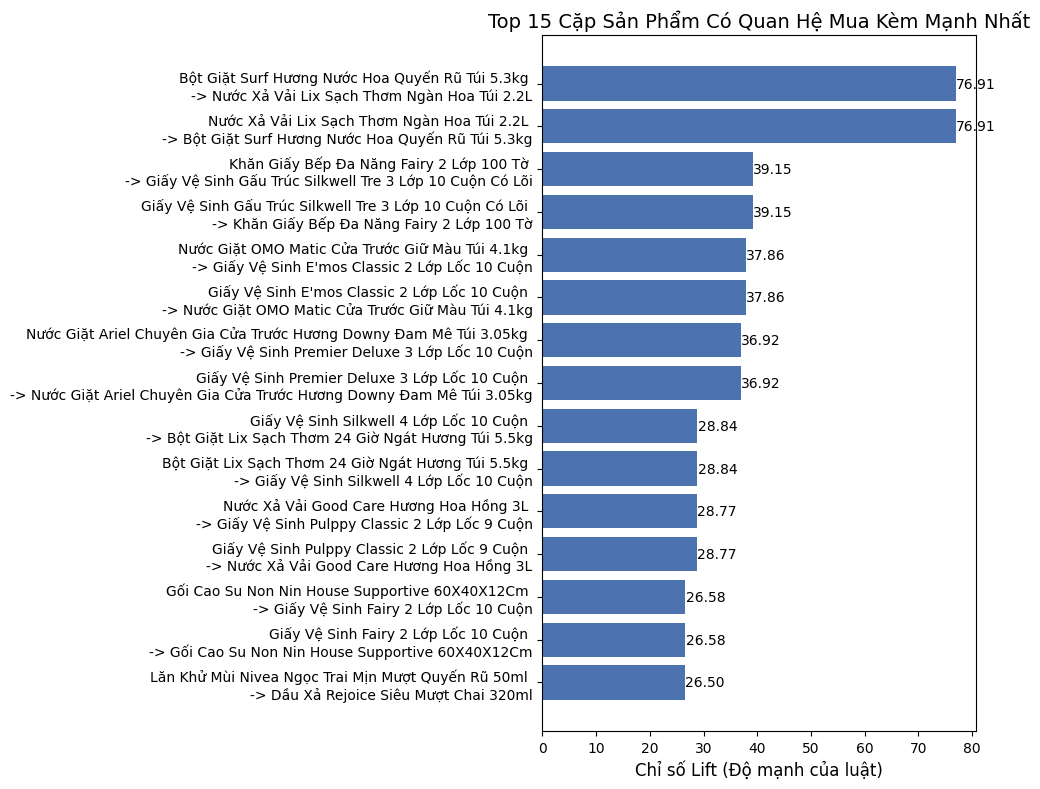

Chi tiết Top 5 Combo:


,antecedent_name,consequent_name,lift,confidence
0,Bột Giặt Surf Hương Nước Hoa Quyến Rũ Túi 5.3kg,Nước Xả Vải Lix Sạch Thơm Ngàn Hoa Túi 2.2L,76.909722,0.416667
1,Nước Xả Vải Lix Sạch Thơm Ngàn Hoa Túi 2.2L,Bột Giặt Surf Hương Nước Hoa Quyến Rũ Túi 5.3kg,76.909722,0.208333
2,Khăn Giấy Bếp Đa Năng Fairy 2 Lớp 100 Tờ,Giấy Vệ Sinh Gấu Trúc Silkwell Tre 3 Lớp 10 Cu...,39.154040,0.388889
3,Giấy Vệ Sinh Gấu Trúc Silkwell Tre 3 Lớp 10 Cu...,Khăn Giấy Bếp Đa Năng Fairy 2 Lớp 100 Tờ,39.154040,0.159091
4,Nước Giặt OMO Matic Cửa Trước Giữ Màu Túi 4.1kg,Giấy Vệ Sinh E'mos Classic 2 Lớp Lốc 10 Cuộn,37.863248,0.384615


In [14]:
# --- TOP 15 COMBO SẢN PHẨM CÓ SỨC MUA KÈM MẠNH NHẤT (Theo Lift) ---
top_item_rules = item_rules.sort_values("lift", ascending=False).head(15).copy()
# Tạo nhãn dễ đọc: "Sản phẩm A  ->  Sản phẩm B"
top_item_rules["rule_name"] = top_item_rules["antecedent_name"] + " \n-> " + top_item_rules["consequent_name"]

plt.figure(figsize=(10, 8))
# Vẽ biểu đồ thanh ngang
bars = plt.barh(top_item_rules["rule_name"], top_item_rules["lift"], color="#4c72b0")
plt.xlabel("Chỉ số Lift (Độ mạnh của luật)", fontsize=12)
plt.title("Top 15 Cặp Sản Phẩm Có Quan Hệ Mua Kèm Mạnh Nhất", fontsize=14)
plt.gca().invert_yaxis() # Đảo ngược để luật mạnh nhất lên đầu

# Thêm chú thích giá trị
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

# Hiển thị bảng chi tiết
print("Chi tiết Top 5 Combo:")
display(top_item_rules[["antecedent_name", "consequent_name", "lift", "confidence"]].head(5))

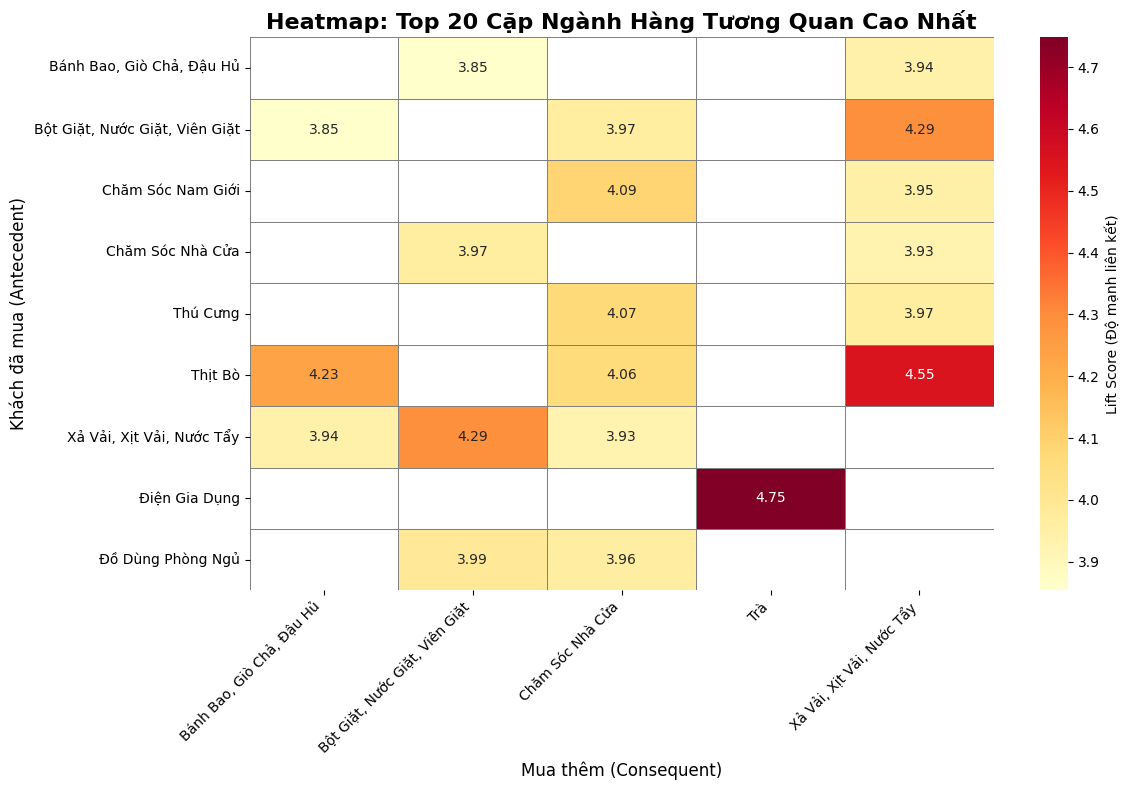

In [15]:
# --- HEATMAP QUAN HỆ CHÉO GIỮA TOP 20 NGÀNH HÀNG (Theo Lift) ---
top_cat_rules = cat_rules.sort_values("lift", ascending=False).head(20)

# Tạo Matrix cho Heatmap
cat_matrix = top_cat_rules.pivot(index="ante_parent_cat", columns="cons_parent_cat", values="lift")

# 4. Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.heatmap(cat_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="YlOrRd", 
            linewidths=.5, 
            linecolor='gray',
            cbar_kws={'label': 'Lift Score (Độ mạnh liên kết)'})

plt.title("Heatmap: Top 20 Cặp Ngành Hàng Tương Quan Cao Nhất", fontsize=16, fontweight='bold')
plt.ylabel("Khách đã mua (Antecedent)", fontsize=12)
plt.xlabel("Mua thêm (Consequent)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

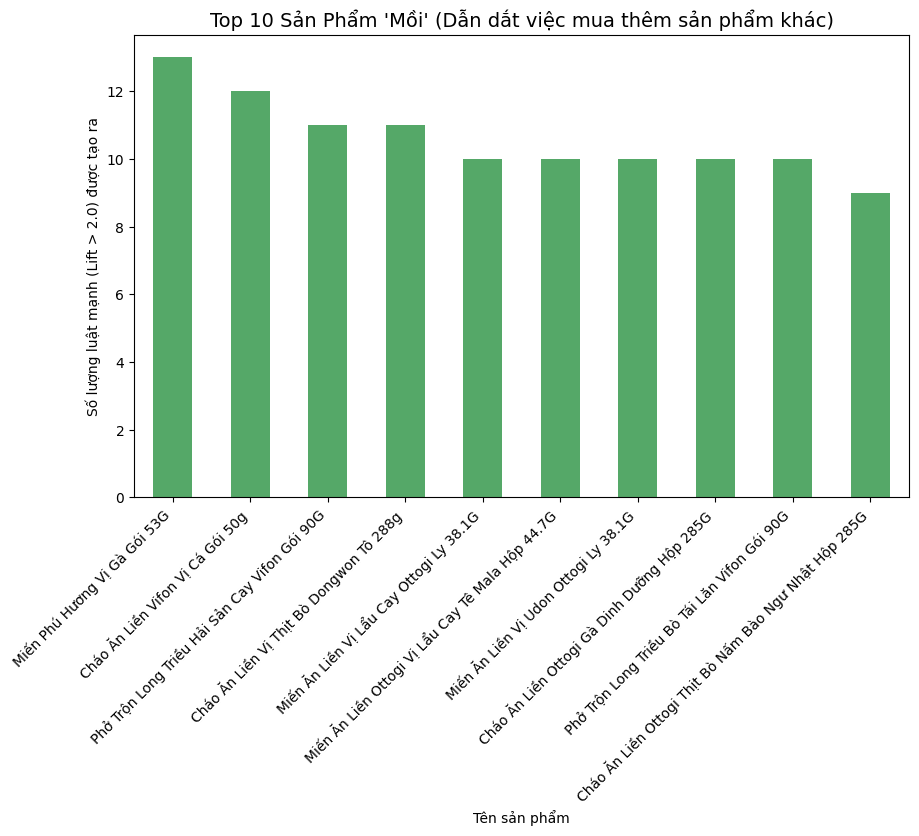

In [16]:
# --- TÌM SẢN PHẨM "MỒI" (DRIVER PRODUCTS) ---
# Đếm số lượng luật mà sản phẩm đóng vai trò là Antecedent (chỉ xét các luật có Lift > 2.0)
strong_rules = item_rules[item_rules['lift'] > 2.0]
driver_counts = strong_rules['antecedent_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
driver_counts.plot(kind='bar', color='#55a868')
plt.title("Top 10 Sản Phẩm 'Mồi' (Dẫn dắt việc mua thêm sản phẩm khác)", fontsize=14)
plt.ylabel("Số lượng luật mạnh (Lift > 2.0) được tạo ra")
plt.xlabel("Tên sản phẩm")
plt.xticks(rotation=45, ha='right')
plt.show()

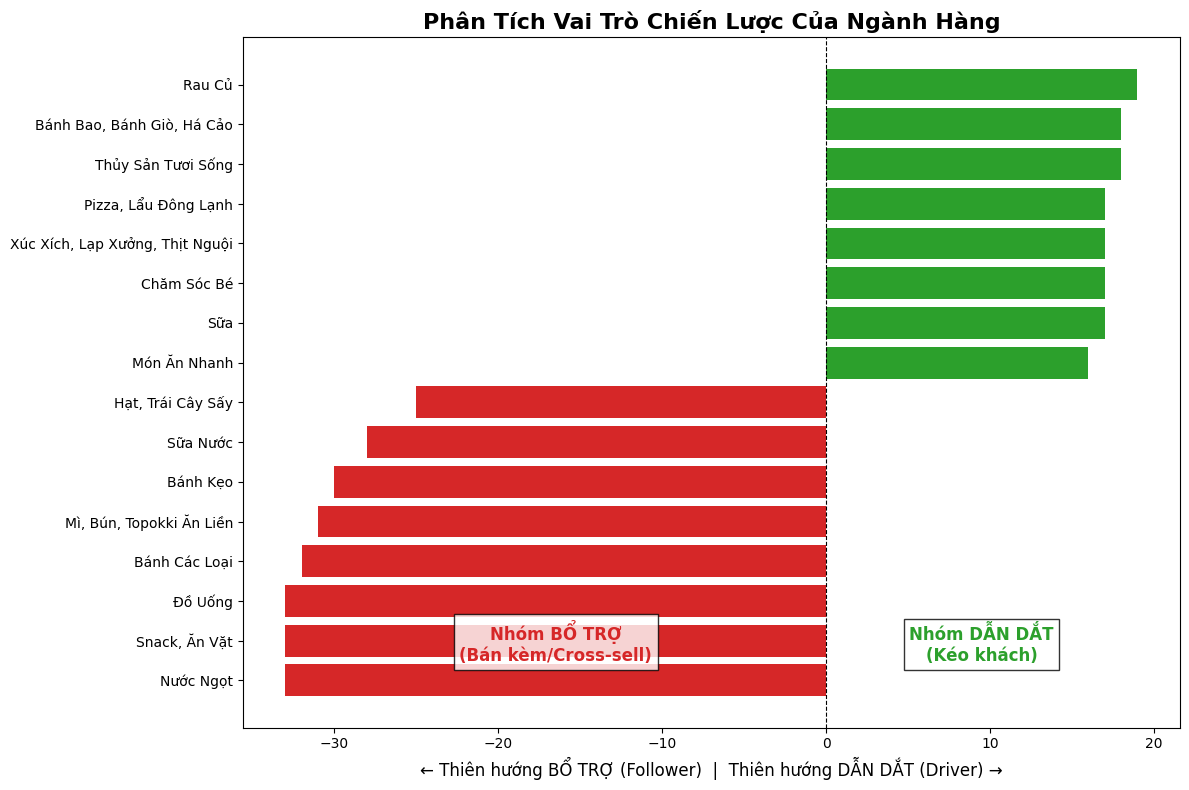

In [17]:
# Tính toán tần suất đóng vai trò
# Đếm số lần mỗi ngành hàng xuất hiện ở vế TRƯỚC (Antecedent - Dẫn dắt)
driver_score = cat_rules['ante_parent_cat'].value_counts().reset_index()
driver_score.columns = ['category', 'ante_count']

# Đếm số lần mỗi ngành hàng xuất hiện ở vế SAU (Consequent - Được mua kèm)
follower_score = cat_rules['cons_parent_cat'].value_counts().reset_index()
follower_score.columns = ['category', 'cons_count']

# Merge
role_df = pd.merge(driver_score, follower_score, on='category', how='outer').fillna(0)

# 3. Tính chỉ số "Vai trò" (Net Role Score)
# Positive (>0): Thiên hướng Dẫn dắt (Mua nó rồi mới mua cái khác)
# Negative (<0): Thiên hướng Bổ trợ (Thường bị mua kèm theo cái khác)
role_df['role_score'] = role_df['ante_count'] - role_df['cons_count']

# Lọc các ngành hàng có ít nhất một lượng luật nhất định để tránh nhiễu
role_df['total_rules'] = role_df['ante_count'] + role_df['cons_count']
active_roles = role_df[role_df['total_rules'] > 5].sort_values('role_score')

# Lấy Top Drivers (Dương lớn nhất) và Top Followers (Âm bé nhất)
top_drivers = active_roles.tail(8)
top_followers = active_roles.head(8)
plot_data = pd.concat([top_followers, top_drivers])

# 4. Vẽ biểu đồ Diverging Bar Chart
plt.figure(figsize=(12, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in plot_data['role_score']] # Đỏ cho Follower, Xanh cho Driver

plt.barh(plot_data['category'], plot_data['role_score'], color=colors)

# Trang trí
plt.title("Phân Tích Vai Trò Chiến Lược Của Ngành Hàng", fontsize=16, fontweight='bold')
plt.xlabel("← Thiên hướng BỔ TRỢ (Follower)  |  Thiên hướng DẪN DẮT (Driver) →", fontsize=12)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')

# Thêm nhãn giải thích
plt.text(plot_data['role_score'].max() * 0.5, 0.5, "Nhóm DẪN DẮT\n(Kéo khách)", 
         color='#2ca02c', fontsize=12, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))
plt.text(plot_data['role_score'].min() * 0.5, 0.5, "Nhóm BỔ TRỢ\n(Bán kèm/Cross-sell)", 
         color='#d62728', fontsize=12, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()